In [94]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("derrom/")
sys.path.append("ELPH/")
sys.path.append("utils/")

import derrom

import PHELPH

kmax = 2.5
n_kmax = 100

tmax = 10000
n_tmax = 1001
t_vec = np.linspace(0,tmax,n_tmax)

system = PHELPH.PHELPH(kmax=kmax, n_kmax=n_kmax)

from ivp_integrator import ivp_integrator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
I_trajectories = derrom.utils.load_trajectories(filename='../PHELPH_I_kmax2.5_nkmax_100_n1000.npz')
el_trajectories = derrom.utils.load_trajectories(filename='../PHELPH_el_kmax2.5_nkmax_100_n1000.npz')
el_scattering = derrom.utils.load_trajectories(filename='../PHELPH_el_scat_kmax2.5_nkmax_100_n1000.npz')

n_sample = 1

I_trajectories = I_trajectories[::n_sample]
el_trajectories = el_trajectories[::n_sample]
el_scattering = el_scattering[::n_sample]

n_trajectories = len(el_trajectories)
n_kmax = el_trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)


cutoff = int(n_trajectories*0.9)

train_I_trajectories = I_trajectories[:cutoff]
train_el_trajectories = el_trajectories[:cutoff]
train_el_scattering = el_scattering[:cutoff]

test_I_trajectories = I_trajectories[cutoff:]
test_el_trajectories = el_trajectories[cutoff:]
test_el_scattering = el_scattering[cutoff:]

1000 loaded with n_kmax = 100


In [111]:
dim_reducer = derrom.dim_reducers.SVD()

# scaler = derrom.scalers.standardize_scaler(1.0)
# transformer = derrom.transformers.ELM_features(ELM_nodes=500)
# optimizer = derrom.optimizers.ridge(alpha=10.**-1)

scaler = derrom.scalers.normalize_scaler(0.1)
transformer = derrom.transformers.polynomial_features(order=2)
optimizer = derrom.optimizers.ridge(alpha=10.**-1)

model = derrom.derrom(train_el_trajectories, train_el_scattering, rdim=15, DE_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    NL_transformer=transformer)

model.train()

model.print_status()

full_hist:  False
intercept:  True
standardize:  True
rdim:  15
DE_l:  2
train shape:  (900900, 496)
target shape:  (900900, 100)
weights shape:  (496, 100)


In [116]:
def derivs(y):
    
    el_hist = y[:,:-1]
    el_state = y[-1,:-1]
    I = y[-1,-1]
    
    df = model.predict(el_hist)
    df += -system.g_photon * I * system.lineshape_vec * (2.*el_state - 1.0)
    
    
    dI = -I/system.tau_photon + I * np.sum(system.I_gain_helper_vec * (2.*el_state - 1.0))
    dI += 1e-9
    
    return np.concatenate((df[0],[dI]))

In [167]:
integrator = ivp_integrator(model, derivs, dt=10.0, dt_out=10., method='Heun')

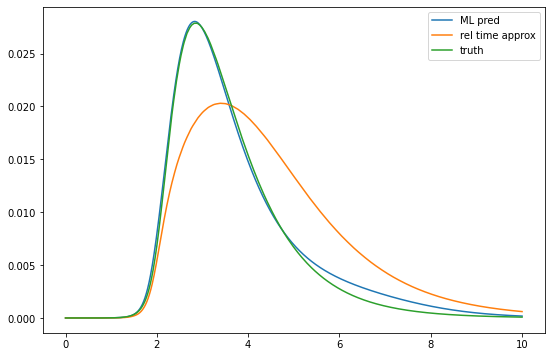

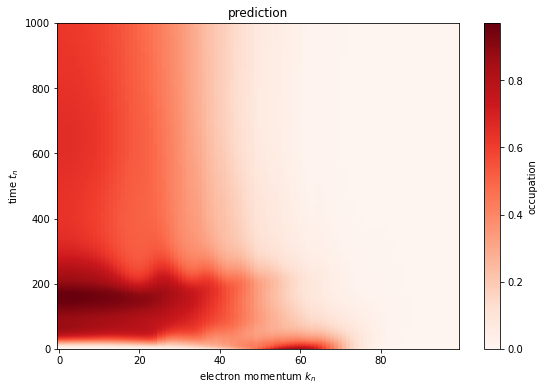

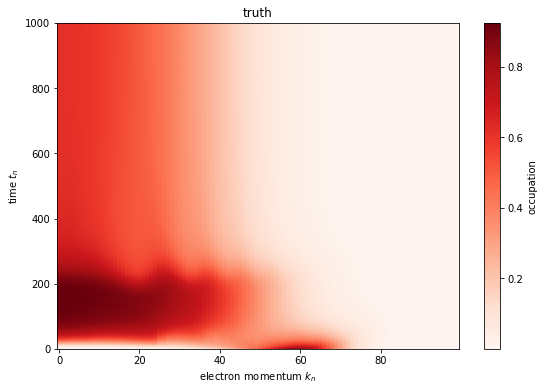

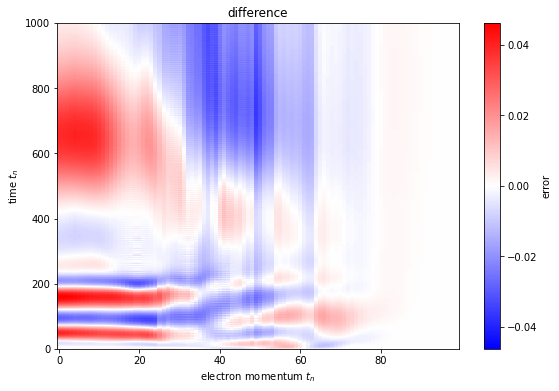

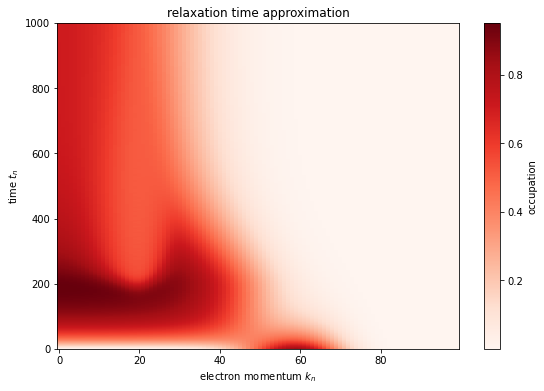

In [175]:
ind = 7

test_el_trajectory = test_el_trajectories[ind]
test_I_trajectory = test_I_trajectories[ind]

inits = np.concatenate((test_el_trajectory[0],[test_I_trajectory[0]])).reshape((1,-1))
# print(inits.shape)


pred = integrator.integrate(inits,test_el_trajectory.shape[0])


rel_time_approx = system.rel_time_approx(inits.flatten(),tmax=tmax, n_tmax=n_tmax)


# print('rms error:', integrator.get_error(test_el_trajectory,pred, norm='rms'))
# print('max error:', integrator.get_error(test_el_trajectory,pred, norm='max'))


plt.plot(t_vec/1000,pred[:,-1],label='ML pred')
plt.plot(t_vec/1000,rel_time_approx[:,-1],label='rel time approx')
plt.plot(t_vec/1000,test_I_trajectory,label='truth')
plt.legend()
plt.show()


derrom.utils.plot_trajectory(pred[:,:-1],title='prediction')

derrom.utils.plot_trajectory(test_el_trajectory,title='truth')

derrom.utils.plot_difference(truth=test_el_trajectory,test=pred[:,:-1])

derrom.utils.plot_trajectory(rel_time_approx[:,:-1],title='relaxation time approximation')
